In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [5]:
import kesh_autoseg_tools as kat

# Intro

The purpose of this notebook is to test a interim solution to automatic segmentation of whole-brain datasets into fascicle models. This interim solution uses freesurfer regions to get in the ballpark, then recobundles to clean up the results and pyAFQ to quantify the metrics along the track and AFQ browser to view the results.

In [39]:
import pandas as pd
import os
from glob import glob

import seaborn as sns
import matplotlib.pyplot as plt

import nilearn.plotting as nip
import nibabel as nib
import dipy as dip

from IPython.display import Image

Set paths

In [7]:
# Select output directory
putdir = './pyAFQuicobundles_freesurfer_test_outputs'
if not os.path.exists(putdir):
    os.mkdir(putdir)

In [8]:
roi_matrix_path = 'WM_pathways_freesurfer_based_seg_EC_KMJmod.xlsx'

pathpath = '/Users/kesshijordan/paths/pyafquicobundles_freesurfer_test_basepath.txt'

with open(pathpath, 'r') as myfile:
    case_basepath = myfile.read().replace('\n', '').replace('\'','')

Load and unpack the streamlines and aparc+aseg file

In [24]:
#aparc aseg file is the freesurfer segmentation
apac_path = glob(os.path.join(case_basepath,'aparc+aseg_di*.nii*'))[0]

#metrics we want to quantify
fa_path = glob(os.path.join(case_basepath, '*_fa.nii*'))[0]
md_path = glob(os.path.join(case_basepath, '*_md.nii*'))[0]

#whole brain tractography we want to segment
wb_path = glob(os.path.join(case_basepath, 'Whole_Brain*newapi.trk'))[0]

In [12]:
tg, hdr = kat.loadtgm_newapi(wb_path)
sls = tg.streamlines
#Only keep streamlines greater than 40mm. We don't really trust segments shorter than this
long_sls = kat.filter_length(sls) 

calc lengths
filter


TEMPLATE INFORMATION

In [26]:
template_basepath = '/Users/kesshijordan/Desktop/IU_Bloomington/qb_templates/Base_CTRL'

# Use the Freesurfer to get in the ballpark

In [27]:
apac_im, apac_data, apac_aff = kat.loadnii(apac_path)
fa_im, fa_data, fa_aff = kat.loadnii(fa_path)
md_im, md_data, md_aff = kat.loadnii(md_path)

In [28]:
roi_matrix = pd.read_excel(roi_matrix_path)
roi_matrix.head()

,VOIS,aparc+aseg,Left ASLANT,Left ARCUATE,Left SLF I,Left SLF II,Left SLF III,Left SLF tp,Left ILF,Left IFOF,...,Right SLF I,Right SLF II,Right SLF III,Right SLF tp,Right ILF,Right IFOF,Right Uncinate,Right MdLF,Right FRONTOCAUDATE,Right FRONTOPUTAMEN
0,ctx-lh-bankssts,1001,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ctx-lh-caudalanteriorcingulate,1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ctx-lh-caudalmiddlefrontal,1003,-1.0,2.0,NaN,1.0,1.0,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ctx-lh-cuneus,1005,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ctx-lh-entorhinal,1006,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


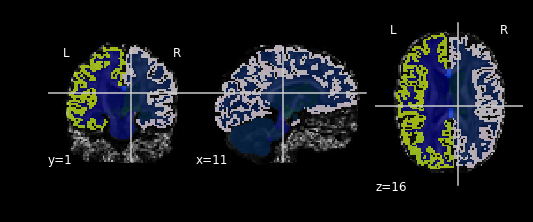

In [29]:
nip.plot_roi(apac_im, bg_img=fa_path)

In [30]:
mydict = kat.build_dict('Left ARCUATE', roi_matrix=roi_matrix)
include, exclude = kat.combine_rois(mydict, apac_data)

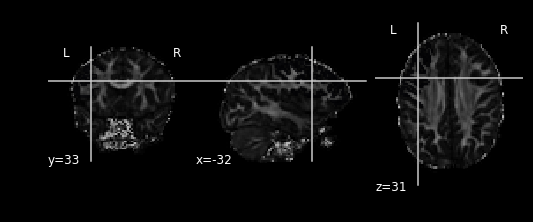

In [31]:
kat.plotroi(include[:,:,:,0], fa_aff, fa_im)

In [32]:
arc = kat.targetme(long_sls, include, exclude, fa_aff)

In [40]:
arc_tgm = nib.streamlines.tractogram.Tractogram(streamlines=arc, affine_to_rasmm=fa_aff)

In [41]:
arc_sls = arc_tgm.streamlines

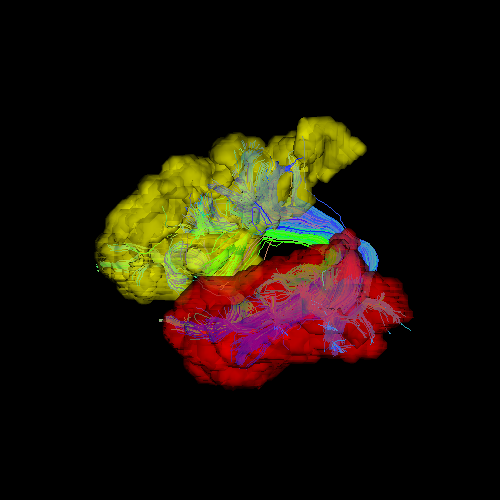

In [33]:
Image(kat.genren_AGG(arc, aff=fa_aff, roi1=include[:,:,:,0], roi2=include[:,:,:,1]))

# Clean up result with Recobundles

In [34]:
wb_template = os.path.join(template_basepath, 'Whole_Brain_long_resaved_newapi.trk')
wb_template_tg, wb_template_hdr = kat.loadtgm_newapi(wb_template)
wb_template_sls = wb_template_tg.streamlines

template_arcuate = '/Users/kesshijordan/Desktop/IU_Bloomington/qb_templates/Arcuate_template.trk'
template_arcuate_tg, template_arcuate_hdr = kat.loadtgm_newapi(template_arcuate)
template_arcuate_sls = template_arcuate_tg.streamlines

## Perform wholebrain Streamline Linear Registration

In [36]:
moved_temp2case, xfm_temp2case, qbc1_temp2pcase, qbc2_temp2case = kat.rough_reg(long_sls[::10], wb_template_sls)

Static streamlines size 78638
Moving streamlines size 108379
Static streamlines after length reduction 63622
Moving streamlines after length reduction 91351
Progressive Registration is Enabled
 Translation  (3 parameters)...
 Rigid  (6 parameters) ...
 Similarity (7 parameters) ...
 Scaling (9 parameters) ...
 Affine (12 parameters) ...
QB static centroids size 258
QB moving centroids size 330
SLR finished in  9.746 seconds.
SLR iterations: 43 


In [42]:
template_arcuate_sls_xfmd = template_arcuate_tg.copy().apply_affine(xfm_temp2case).streamlines

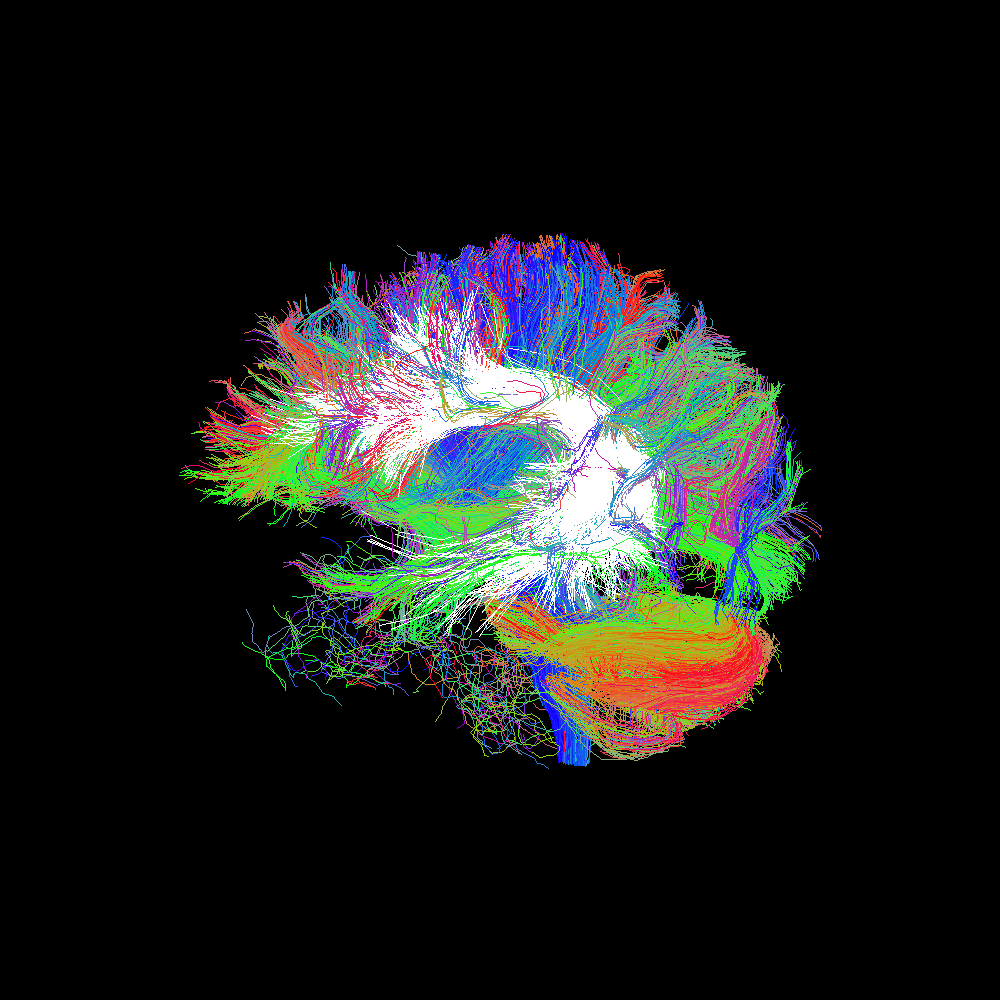

In [44]:
Image(kat.genren_AGG(long_sls[::100], sls2=template_arcuate_sls_xfmd, putpath='test.png'), width=400,height=400)

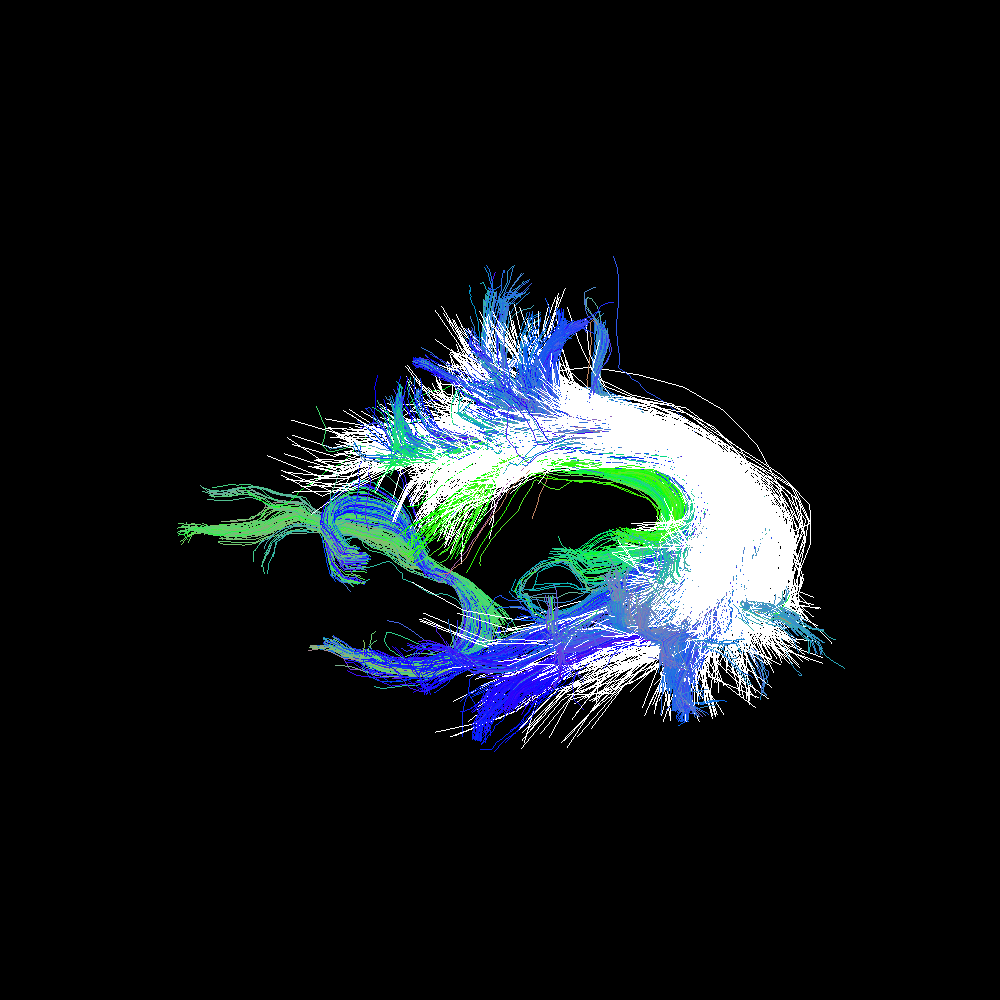

In [45]:
Image(kat.genren_AGG(arc, sls2=template_arcuate_sls_xfmd, putpath='test.png'), width=400,height=400)

## Run a second Streamline Linear Registration on just the freesurfer results and the template to get a better local match

(This is important for tracks like the Uncinate, which have bad fits when the wholebrain is registered linearly)

In [46]:
template_arcuate_sls_xfmd_slr = kat.runslr(arc, template_arcuate_sls_xfmd, npts=10)

None
False


In [49]:
template_arcuate_sls_xfmd_slr_sls = nib.streamlines.tractogram.Tractogram(streamlines=template_arcuate_sls_xfmd_slr, affine_to_rasmm=fa_aff).streamlines

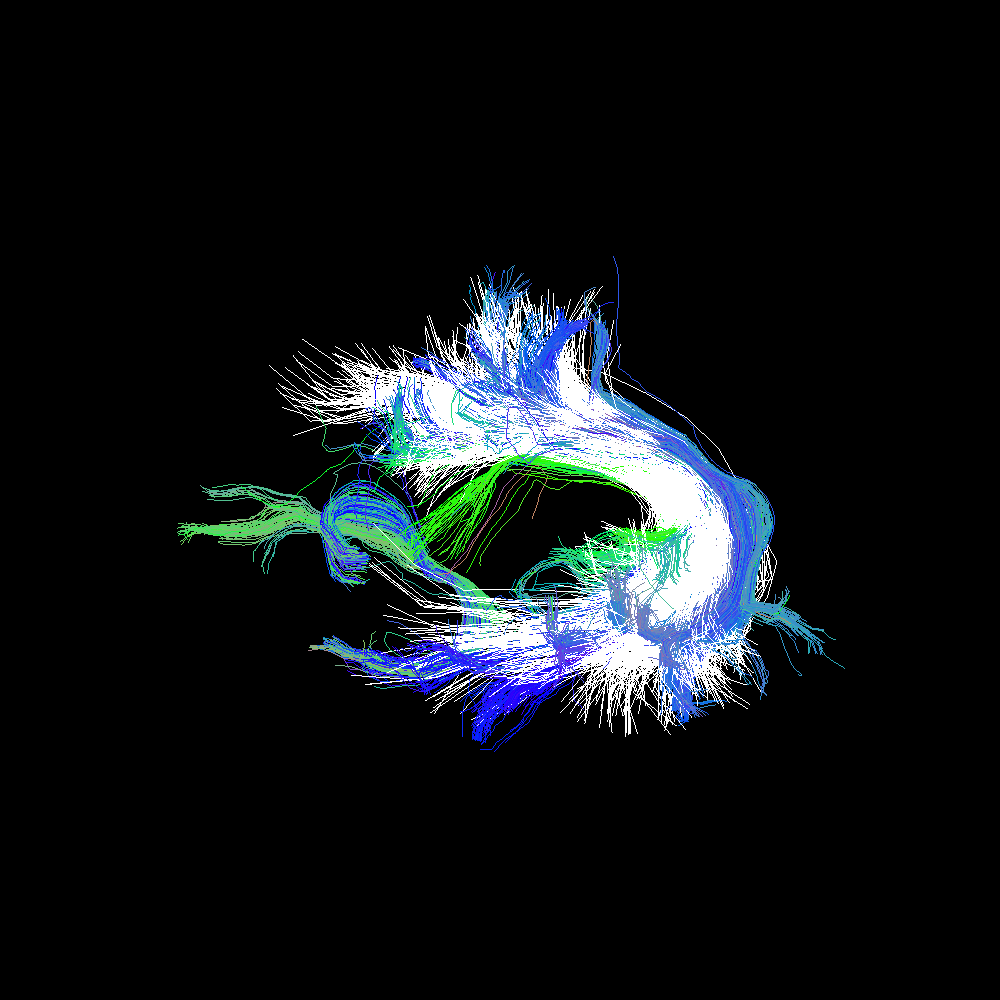

In [51]:
Image(kat.genren_AGG(arc, sls2=template_arcuate_sls_xfmd_slr, putpath='test.png'), width=400,height=400)

## Run recobundles

In [52]:
rb_arcuate, ig_ip = kat.run_rb(template_arcuate_sls_xfmd_slr_sls, arc_sls)

 Resampled to 20 points
 Size is 0.478 MB
 Duration of resampling is 0.009 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 2089 random streamlines
 Duration 0.052 sec. 

 Streamlines have 22 centroids
 Total loading duration 0.000 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBX
 Model bundle has 1039 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.476 MB
 Duration of resampling is 0.006 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.070 sec. 

 Model bundle has 108 centroids
 Duration 0.077 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 1852
 Duration 0.025 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 4.886
 Number of iterations 60
 Matrix size (4, 4)
[[ 0.949  0.019 -0.056 -1.072]
 [-0.015  0.948  0.075  1.857]
 [ 0.057 -0.074  0.946

Streamlines selected by recobundles (white) from the freesurfer target output

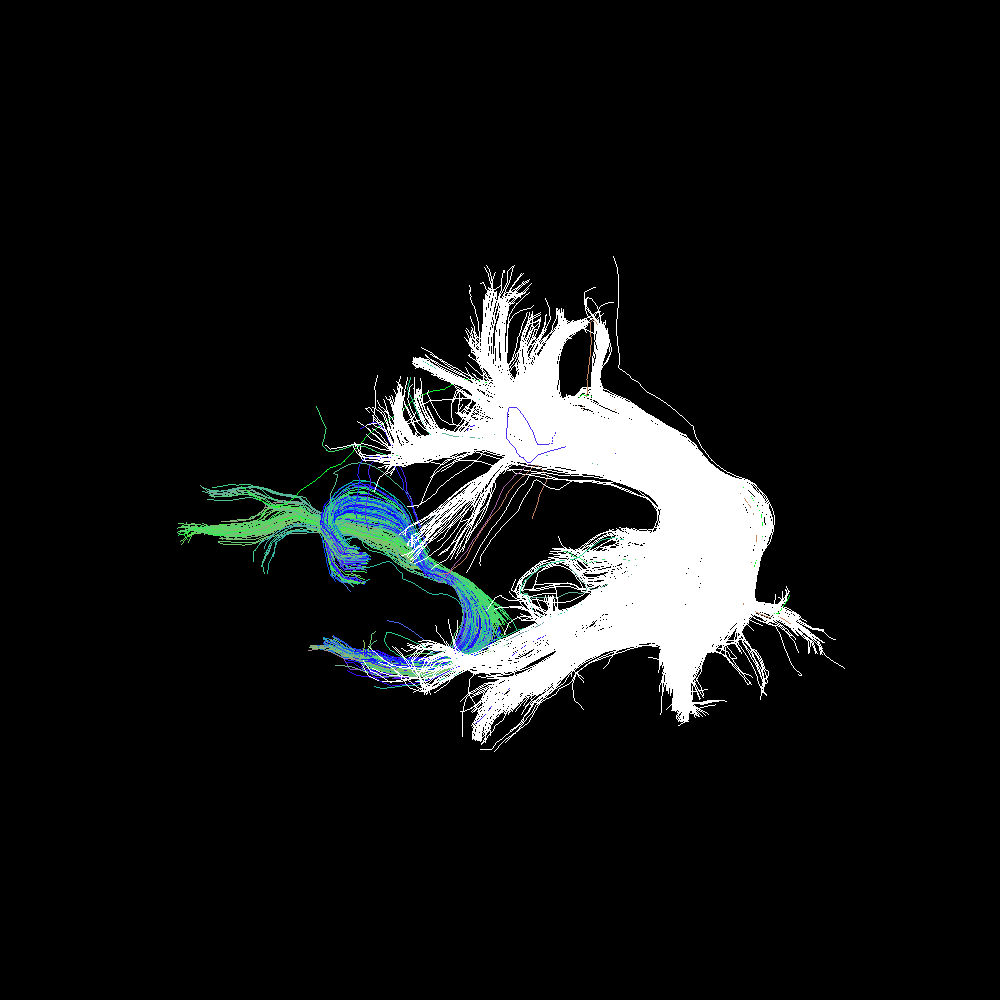

In [56]:
Image(kat.genren_AGG(arc, sls2=rb_arcuate, putpath='test.png'), width=400,height=400)

Final output of the freesurfer/recobundles segmentation

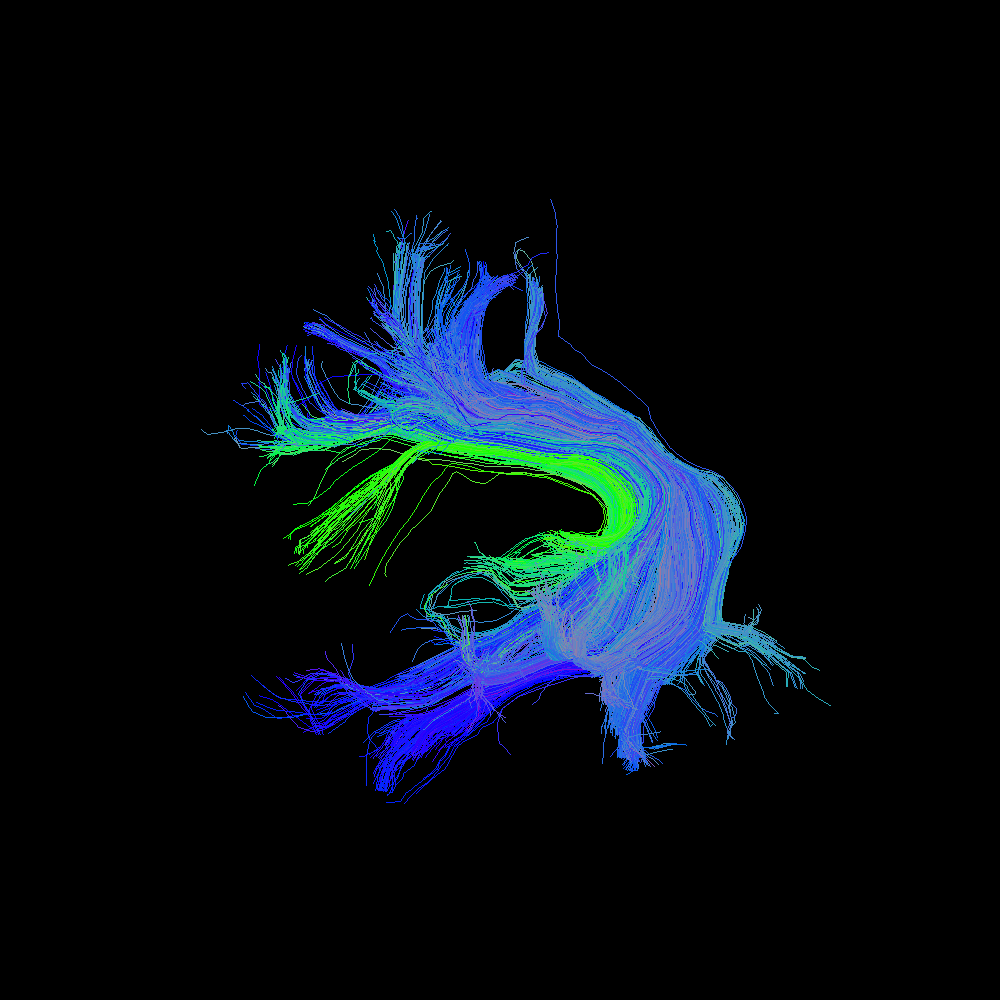

In [57]:
Image(kat.genren_AGG(rb_arcuate, putpath='test.png'), width=400,height=400)

# AFQ

In [58]:
from AFQ.segmentation import calculate_tract_profile, gaussian_weights

In [59]:
profile_arcuate = calculate_tract_profile(fa_data, list(rb_arcuate), affine=fa_aff)

In [60]:
gweights = gaussian_weights(list(rb_arcuate))
profile_arcuate_gweights = calculate_tract_profile(fa_data, list(rb_arcuate), affine=fa_aff, weights=gweights)

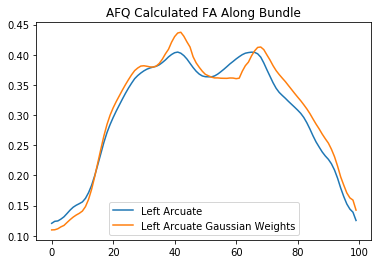

In [61]:
fig, ax = plt.subplots(1)
ax.plot(profile_arcuate, label='Left Arcuate')
ax.plot(profile_arcuate_gweights, label='Left Arcuate Gaussian Weights')
ax.set_title('AFQ Calculated FA Along Bundle')
ax.legend()

# Now batch it

In [62]:
pathpath_template = '/Users/kesshijordan/paths/child_single_subject_template_basepath.txt'

In [63]:
with open(pathpath_template, 'r') as myfile:
    template_basepath = myfile.read().replace('\n', '').replace('\'','')

In [66]:
template_list = os.listdir(os.path.join(template_basepath,'TRACKs'))

wb_template_child = glob(os.path.join(template_basepath, 'TRACKs/Whole*newapi.trk'))[0]

wb_template_child_tg, wb_template_child_hdr = kat.loadtgm_newapi(wb_template_child)
backuptrk, backuphdr = nib.trackvis.read(wb_template_child)

wb_template_child_sls = wb_template_tg.streamlines

In [66]:
backuptrk, backuphdr = nib.trackvis.read(wb_template_child)

In [223]:
moved_temp2case_child, xfm_temp2case_child, qbc1_temp2pcase_child, qbc2_temp2case_child = kat.rough_reg(long_sls, wb_template_child_sls)

Static streamlines size 786378
Moving streamlines size 108379
Static streamlines after length reduction 636984
Moving streamlines after length reduction 91351
Progressive Registration is Enabled
 Translation  (3 parameters)...
 Rigid  (6 parameters) ...
 Similarity (7 parameters) ...
 Scaling (9 parameters) ...
 Affine (12 parameters) ...
QB static centroids size 642
QB moving centroids size 330
SLR finished in  29.947 seconds.
SLR iterations: 81 


In [226]:
import pickle
pickle.dump(xfm_temp2case_child, open(os.path.join(putdir, "wbslr_childtemp2test.pkl"), "wb"))

In [68]:
import re
prog = re.compile(r'Left*|Right*')
cols = roi_matrix.columns
track_list = cols[[bool(prog.match(i)) for i in cols]]

In [71]:
dictionary = {}
for tr in track_list:
    dictionary[tr] = build_dict(tr, roi_matrix=roi_matrix)

In [72]:
dictionary.keys()

dict_keys(['Left ASLANT', 'Left ARCUATE', 'Left SLF I', 'Left SLF II', 'Left SLF III', 'Left SLF tp', 'Left ILF', 'Left IFOF', 'Left Uncinate', 'Left MdLF', 'Left FRONTOCAUDATE', 'Left FRONTOPUTAMEN', 'Right ASLANT', 'Right ARCUATE', 'Right SLF I', 'Right SLF II', 'Right SLF III', 'Right SLF tp', 'Right ILF', 'Right IFOF', 'Right Uncinate', 'Right MdLF', 'Right FRONTOCAUDATE', 'Right FRONTOPUTAMEN'])

In [73]:
dictionary['Left FRONTOPUTAMEN']

{'exclude': {'set-1': {'Brain-Stem': 16,
   'Left-Caudate': 11,
   'Left-Pallidum': 13,
   'Left-Thalamus proper': 10,
   'ctx-lh-temporalpole': 1033}},
 'include': {'set1': {'ctx-lh-caudalanteriorcingulate': 1002,
   'ctx-lh-caudalmiddlefrontal': 1003,
   'ctx-lh-frontalpole': 1032,
   'ctx-lh-lateralorbitofrontal': 1012,
   'ctx-lh-medialorbitofrontal': 1014,
   'ctx-lh-parsopercularis': 1018,
   'ctx-lh-parsorbitalis': 1019,
   'ctx-lh-parstriangularis': 1020,
   'ctx-lh-precentral': 1024,
   'ctx-lh-rostralanteriorcingulate': 1026,
   'ctx-lh-superiorfrontal': 1028},
  'set2': {'Left-Putamen': 12}}}

Don't forget to rerun with non-subsampled template if needed? Just switched template acquisition function

In [ ]:
def segment_tracks(dictionary, template_paths, ):
    for i in list(dictionary.keys())[15:]:
        template_name = convert_filename(i, template_paths)
    
        if template_name is None:
            print('Did not find match')
            continue
        
        

In [74]:
fa_df = pd.DataFrame()
fa_df_gwt = pd.DataFrame()

md_df = pd.DataFrame()
md_df_gwt = pd.DataFrame()

In [76]:
file_map_path = 'WM_pathways_recobundles_based_seg.xlsx'
file_map = pd.read_excel(file_map_path, index_col='column_name')
file_map.head()

,file_name
column_name,
Left ASLANT,Aslant_L.trk
Left ARCUATE,Arcuate_L.trk
Left SLF I,SLF_IP_I_L.trk
Left SLF II,SLF_IP_II_L.trk
Left SLF III,SLF_IP_III_L.trk


In [237]:
track_list_df = pd.read_excel('WM_pathways_track_list.xlsx', index_col='column_name')
track_list = list(track_list_df[track_list_df.segment_this>0].index)
track_list_df.head()

,segment_this
column_name,
Left ASLANT,1
Left ARCUATE,1
Left SLF I,1
Left SLF II,1
Left SLF III,1


In [232]:
def template_dict_from_excel(template_csv_path):
    track_list_df = pd.read_excel(template_csv_path, index_col='column_name')
    track_list = list(track_list_df[track_list_df.segment_this>0].index)
    template_dict = {}
    for t in track_list:
        template_dict[t]={}
        temp_path = kat.convert_filename(t, os.listdir(template_basepath+'TRACKs'))
        glob_list = glob(os.path.join(template_basepath, 'TRACKs/'+file_map.loc[t][0]))
        if len(glob_list)==1:
            template_dict[t]['tgm'],template_dict[t]['hdr'] = kat.loadtgm_newapi(glob_list[0])
        else:
            print('Need exactly one template')
            print(glob_list)
        
    return template_dict
        
temp_dict = template_dict_from_excel('WM_pathways_track_list.xlsx')

Need exactly one match for Left SLF I
(?i)(SLF.IP_I)_L.trk
[]
Need exactly one template
[]
Need exactly one match for Left MdLF
(?i)(MdLF)_L.trk
[]
Need exactly one template
[]
Need exactly one match for Right SLF I
(?i)(SLF.IP_I)_R.trk
[]
Need exactly one template
[]
Need exactly one match for Right MdLF
(?i)(MdLF)_R.trk
[]
Need exactly one template
[]


In [238]:
len(track_list)

24

In [235]:
temp_dict.keys()

dict_keys(['Left ASLANT', 'Left ARCUATE', 'Left SLF I', 'Left SLF II', 'Left SLF III', 'Left SLF tp', 'Left ILF', 'Left IFOF', 'Left Uncinate', 'Left MdLF', 'Left FRONTOCAUDATE', 'Left FRONTOPUTAMEN', 'Right ASLANT', 'Right ARCUATE', 'Right SLF I', 'Right SLF II', 'Right SLF III', 'Right SLF tp', 'Right ILF', 'Right IFOF', 'Right Uncinate', 'Right MdLF', 'Right FRONTOCAUDATE', 'Right FRONTOPUTAMEN'])

In [243]:
def run_kesh_autoseg(wb_subject_tg, wb_subject_hdr, wb_template_tg, track_template_tg_dict, 
                     roi_matrix_path, file_map_path, apac_image, outdir='.', 
                     basename='test', length_thresh=None, prune_thresh=10, 
                     save_snapshot=False, slr_pkl=None, flexi_prune_thresh=False):
    '''
    wb_template_tg: the template wholebrain tractogram (nibabel streamline API)
    trk_template_tg_dict: dictionary of tractograms with dictionary 'hdr' 'tgm' 
                          providing the loaded header and tractogram
    roi_matrix_path: excel file coding for inclusion/exclusion freesurfer ROIs
    file_map_path: excel file mapping the column names in roi_matrix to file names 
                   of template
    apac_image: loaded aparc aseg image (nibabel API)
    '''
    
    info={}
    
    #Load the data frames specifying inclusion/exclusion criteria
    roi_matrix = pd.read_excel(roi_matrix_path)
    file_map = pd.read_excel(file_map_path, index_col='column_name')
    
    #Load aparc aseg image
    if length_thresh is not None:
        wb_subject_sls = kat.filter_length(wb_subject_tg.streamlines, length_thresh)
    else:
        wb_subject_sls = wb_subject_tg.streamlines

    wb_template_sls = wb_template_tg.streamlines
    
    #Bring streamline templates into the subject space
    if slr_pkl is not None:
        #load from pickle if this is pre-computed
        print('Loading transform from pickle')
        xfm_t2s = pickle.load(open(slr_pkl, "rb"))
    else:
        #otherwise register the whole brain
        moved_t2s, xfm_t2s, qb1, qb2 = kat.rough_reg(wb_subject_sls, 
                                                         wb_template_sls)
    
    #Build dictionary of include/exclude rois and freesurfer codes from roi_matrix
    roi_dict = {}
    for tr in track_list:
        roi_dict[tr] = kat.build_dict(tr, roi_matrix=roi_matrix)
        
    clmp=None
    for tr in track_list:
        uhoh_list=[]
        usname = tr.replace(' ','_')
        savename = basename + '_' + usname
        info[tr]={}
        
        print(tr)
        
        try:
        #FREESURFER TARGETING
            print('targeting')
            include, exclude = kat.combine_rois(roi_dict[tr], apac_data)
            fs_output = kat.targetme(wb_subject_sls, include, exclude, apac_image.affine)
            fs_tgm = nib.streamlines.tractogram.Tractogram(streamlines=fs_output, 
                                                           affine_to_rasmm=fa_aff)
            fs_sls = fs_tgm.streamlines
        except:
            print('freesurfer_error')
            uhoh_list.append('freesurfer_error')
        
        
        #RECOBUNDLES
        
        slr_bounds = [(-30, 30), (-30, 30), (-30, 30), (-45, 45), (-45, 45), (-45, 45)]
        
        try:
            tr_tgm=track_template_tg_dict[tr]['tgm'].copy()
            template_xfmd = tr_tgm.copy().apply_affine(xfm_temp2case).streamlines
            template_xfmd_slr = kat.runslr(fs_sls, template_xfmd, npts=10, bounds=slr_bounds)
            template_xfmd_slr_sls = nib.streamlines.tractogram.Tractogram(streamlines=template_xfmd_slr, 
                                                                          affine_to_rasmm=fa_aff).streamlines

            '''if clmp is not None:
                #this will speed up recobundles if it's been run before
                rb, clmp = kat.run_rb(template_xfmd_slr_sls, fs_sls, cluster_map=clmp,
                                  pruning_thr=prune_thresh)
            else:'''
            rb, clmp = kat.run_rb(template_xfmd_slr_sls, fs_sls, pruning_thr=prune_thresh)

            if flexi_prune_thresh:
                while len(rb) < 10 and prune_thresh<80:
                    prune_thresh += 10
                    print("INCREASED PRUNING THRESHOLD %i" % prune_thresh)
                    rb, clmp = kat.run_rb(template_xfmd_slr_sls, fs_sls, cluster_map=clmp,
                                      pruning_thr=prune_thresh)

            info[tr]['final_pruning_thresh'] = prune_thresh

            if len(rb)>0:
                kat.save_old_trk(rb, wb_subject_hdr, apac_image, 
                             os.path.join(outdir, savename+'.trk'))
        except:
            print('recobundles_error')
            uhoh_list.append('recobundles_error')
        
        if save_snapshot:
            try:
                Image(kat.genren_AGG(fs_sls, aff=apac_im.affine, roi1=include[:,:,:,0], 
                                     roi2=include[:,:,:,1], 
                                     putpath=outdir+'/'+savename+'_sshot_1_fs.png'), 
                      width=400,height=400)
                Image(kat.genren_AGG(fs_sls, sls2=template_xfmd_slr_sls, 
                                     putpath=outdir+'/'+savename+'_sshot_2_slr.png'), 
                      width=400,height=400)
                Image(kat.genren_AGG(fs_sls, sls2=rb, 
                                     putpath=outdir+'/'+savename+'_sshot_3_rb_fs.png'), 
                      width=400,height=400)
                Image(kat.genren_AGG(rb, 
                                     putpath=outdir+'/'+savename+'_sshot_4_rb_final.png'), 
                      width=400,height=400)
            except:
                print('Cound not take all snapshots')
                uhoh_list.append('snapshots_error')
            
            info[tr]['errors'] = uhoh_list

    print('done')
    print(info)
    return info

uhoh = run_kesh_autoseg(tg, hdr, wb_template_tg, temp_dict, roi_matrix_path,
                        file_map_path,  apac_im, outdir=putdir, length_thresh=40, 
                        save_snapshot=True, flexi_prune_thresh=True, 
                        slr_pkl='pyAFQuicobundles_freesurfer_test_outputs/wbslr_childtemp2test.pkl')

calc lengths
filter
Loading transform from pickle
Left ASLANT
targeting
[(-30, 30), (-30, 30), (-30, 30), (-45, 45), (-45, 45), (-45, 45)]
False
 Resampled to 20 points
 Size is 0.441 MB
 Duration of resampling is 0.019 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 1926 random streamlines
 Duration 0.042 sec. 

 Streamlines have 15 centroids
 Total loading duration 0.001 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBX
 Model bundle has 4963 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 2.272 MB
 Duration of resampling is 0.013 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.197 sec. 

 Model bundle has 43 centroids
 Duration 0.211 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 1902
 Duration 0.021 sec. 

# Local SLR of neighb_streamlines to model
 Square-root o

Left ILF
targeting
[(-30, 30), (-30, 30), (-30, 30), (-45, 45), (-45, 45), (-45, 45)]
False
 Resampled to 20 points
 Size is 0.461 MB
 Duration of resampling is 0.008 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 2015 random streamlines
 Duration 0.036 sec. 

 Streamlines have 17 centroids
 Total loading duration 0.000 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBX
 Model bundle has 485 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.222 MB
 Duration of resampling is 0.005 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.021 sec. 

 Model bundle has 40 centroids
 Duration 0.027 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 1627
 Duration 0.019 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 3.808
 Number of iterations 62
 Matrix size (

 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.198 sec. 

 QB Duration 0.214 sec. 

 Using MDF
 Pruning matrix size is (96, 138)
 Number of centroids: 138
 Number of streamlines after pruning: 7859
 Duration 0.240 sec. 

Total duration of recognition time is 11.559 sec.

Right ASLANT
targeting
[(-30, 30), (-30, 30), (-30, 30), (-45, 45), (-45, 45), (-45, 45)]
False
 Resampled to 20 points
 Size is 0.325 MB
 Duration of resampling is 0.009 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 1422 random streamlines
 Duration 0.034 sec. 

 Streamlines have 8 centroids
 Total loading duration 0.000 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBX
 Model bundle has 3583 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 1.640 MB
 Duration of resampling is 0.009 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.11

Right ILF
targeting
[(-30, 30), (-30, 30), (-30, 30), (-45, 45), (-45, 45), (-45, 45)]
False
 Resampled to 20 points
 Size is 0.499 MB
 Duration of resampling is 0.008 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 2178 random streamlines
 Duration 0.043 sec. 

 Streamlines have 21 centroids
 Total loading duration 0.000 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBX
 Model bundle has 429 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.196 MB
 Duration of resampling is 0.006 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.024 sec. 

 Model bundle has 40 centroids
 Duration 0.031 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 1726
 Duration 0.022 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 4.451
 Number of iterations 58
 Matrix size 

done
{'Left ASLANT': {'final_pruning_thresh': 10, 'errors': []}, 'Left ARCUATE': {'final_pruning_thresh': 10, 'errors': []}, 'Left SLF I': {'errors': ['recobundles_error']}, 'Left SLF II': {'final_pruning_thresh': 10, 'errors': []}, 'Left SLF III': {'final_pruning_thresh': 10, 'errors': []}, 'Left SLF tp': {'final_pruning_thresh': 10, 'errors': []}, 'Left ILF': {'final_pruning_thresh': 10, 'errors': []}, 'Left IFOF': {'final_pruning_thresh': 10, 'errors': []}, 'Left Uncinate': {'final_pruning_thresh': 10, 'errors': []}, 'Left MdLF': {'errors': ['recobundles_error', 'snapshots_error']}, 'Left FRONTOCAUDATE': {'final_pruning_thresh': 10, 'errors': []}, 'Left FRONTOPUTAMEN': {'final_pruning_thresh': 10, 'errors': []}, 'Right ASLANT': {'final_pruning_thresh': 10, 'errors': []}, 'Right ARCUATE': {'final_pruning_thresh': 10, 'errors': []}, 'Right SLF I': {'errors': ['recobundles_error']}, 'Right SLF II': {'final_pruning_thresh': 10, 'errors': []}, 'Right SLF III': {'final_pruning_thresh': 10

In [285]:
uhoh

{'Left ARCUATE': {'errors': [], 'final_pruning_thresh': 10},
 'Left ASLANT': {'errors': [], 'final_pruning_thresh': 10},
 'Left FRONTOCAUDATE': {'errors': [], 'final_pruning_thresh': 10},
 'Left FRONTOPUTAMEN': {'errors': [], 'final_pruning_thresh': 10},
 'Left IFOF': {'errors': [], 'final_pruning_thresh': 10},
 'Left ILF': {'errors': [], 'final_pruning_thresh': 10},
 'Left MdLF': {'errors': ['recobundles_error', 'snapshots_error']},
 'Left SLF I': {'errors': ['recobundles_error']},
 'Left SLF II': {'errors': [], 'final_pruning_thresh': 10},
 'Left SLF III': {'errors': [], 'final_pruning_thresh': 10},
 'Left SLF tp': {'errors': [], 'final_pruning_thresh': 10},
 'Left Uncinate': {'errors': [], 'final_pruning_thresh': 10},
 'Right ARCUATE': {'errors': [], 'final_pruning_thresh': 10},
 'Right ASLANT': {'errors': [], 'final_pruning_thresh': 10},
 'Right FRONTOCAUDATE': {'errors': [], 'final_pruning_thresh': 10},
 'Right FRONTOPUTAMEN': {'errors': [], 'final_pruning_thresh': 10},
 'Right IF

In [251]:
segmented_trks = glob('pyAFQuicobundles_freesurfer_test_outputs/test*.trk')

In [280]:
def get_profiles(trk_list, fa_data, md_data):
    fa_df = pd.DataFrame()
    fa_df_gwt = pd.DataFrame()

    md_df = pd.DataFrame()
    md_df_gwt = pd.DataFrame()
    
    for t in trk_list:
        trkname = ' '.join(t.split('/')[-1].split('.')[0].split('_')[1:])
        tgm,hdr = kat.loadtgm_newapi(t)
        sls = list(tgm.streamlines)
        profile_fa = calculate_tract_profile(fa_data, 
                                             sls, 
                                             affine=hdr['voxel_to_rasmm'])
        profile_md = calculate_tract_profile(md_data, 
                                             sls, 
                                             affine=hdr['voxel_to_rasmm'])
        
        gweights = gaussian_weights(sls)
        profile_gweights_fa = calculate_tract_profile(fa_data, sls, affine=fa_aff, 
                                                      weights=gweights)
        profile_gweights_md = calculate_tract_profile(md_data, sls, affine=fa_aff, 
                                                      weights=gweights)
        
        fa_df[trkname] = profile_fa
        md_df[trkname] = profile_md
        fa_df_gwt[trkname] = profile_gweights_fa
        md_df_gwt[trkname] = profile_gweights_md
        
    return fa_df, md_df, fa_df_gwt, md_df_gwt
        
fa_df, md_df, fa_df_gwt, md_df_gwt = get_profiles(segmented_trks, fa_data, md_data)

In [281]:
fa_df.head()

,Right ARCUATE,Right SLF III,Left Uncinate,Left SLF tp,Right ASLANT,Left SLF II,Right IFOF,Right ILF,Left FRONTOCAUDATE,Left SLF III,Right FRONTOCAUDATE,Left ARCUATE,Right SLF tp,Left ASLANT,Left IFOF,Right FRONTOPUTAMEN,Right SLF II,Left FRONTOPUTAMEN,Left ILF,Right Uncinate
0,0.143422,0.151916,0.153760,0.125658,0.189367,0.133315,0.125524,0.126722,0.116187,0.133107,0.137960,0.121496,0.124878,0.095188,0.150339,0.171830,0.129971,0.145401,0.129983,0.172020
1,0.148473,0.165653,0.161680,0.134115,0.160609,0.136114,0.133639,0.128633,0.119733,0.129551,0.140430,0.124498,0.127149,0.097239,0.161346,0.183649,0.127658,0.152484,0.133809,0.178649
2,0.147199,0.167696,0.167284,0.135028,0.137979,0.140563,0.136620,0.127685,0.124929,0.124033,0.144141,0.125012,0.128251,0.102906,0.174474,0.195094,0.124495,0.159907,0.137137,0.182020
3,0.143450,0.164550,0.172232,0.131296,0.126236,0.147412,0.146598,0.124931,0.131180,0.122736,0.147315,0.127647,0.128447,0.111877,0.186490,0.202827,0.122579,0.167869,0.146130,0.184783
4,0.137671,0.163485,0.178111,0.126939,0.125590,0.154658,0.166159,0.123362,0.138452,0.125321,0.150121,0.131405,0.129961,0.121333,0.192725,0.206768,0.121664,0.175703,0.156567,0.186340


In [286]:
def plotme(df, title):
    fig, ax = plt.subplots(1)
    df.plot(ax=ax, title=title)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

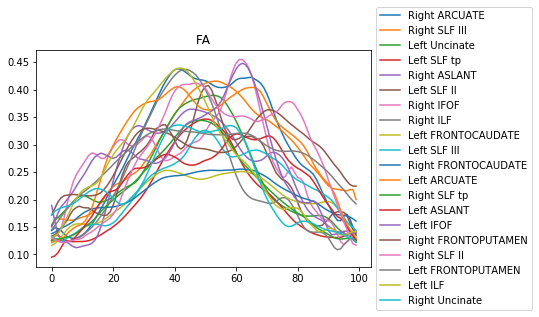

In [287]:
plotme(fa_df, 'FA')

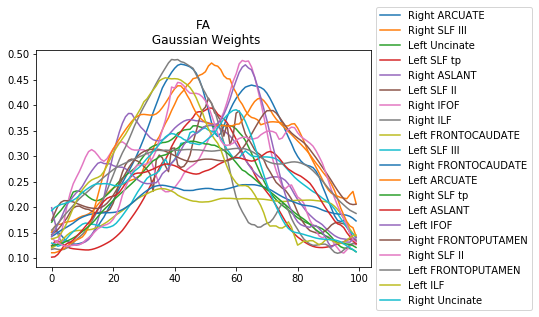

In [292]:
plotme(fa_df_gwt, 'FA\n Gaussian Weights')

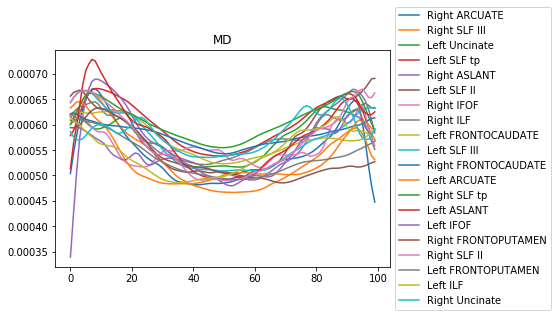

In [288]:
plotme(md_df, 'MD')

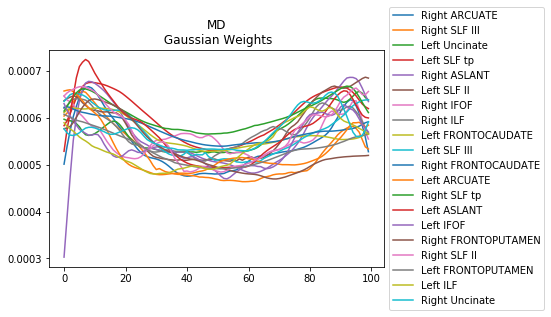

In [291]:
plotme(md_df_gwt, 'MD\n Gaussian Weights')

In [293]:
fa_df.to_csv(os.path.join(putdir, 'fa_df.csv'), index=False)
fa_df_gwt.to_csv(os.path.join(putdir, 'md_df_gwt.csv'), index=False)

md_df.to_csv(os.path.join(putdir, 'md_df.csv'), index=False)
md_df_gwt.to_csv(os.path.join(putdir, 'md_df_gwt.csv'), index=False)

This is why we need to use bundle-to-bundle streamline linear registration here as a secondary registration after the whole brain SLR... the geometries of the brain do not match well so the freesurfer output doesn't line up with the initial position of the transformed template (transformed using whole brain SLR)

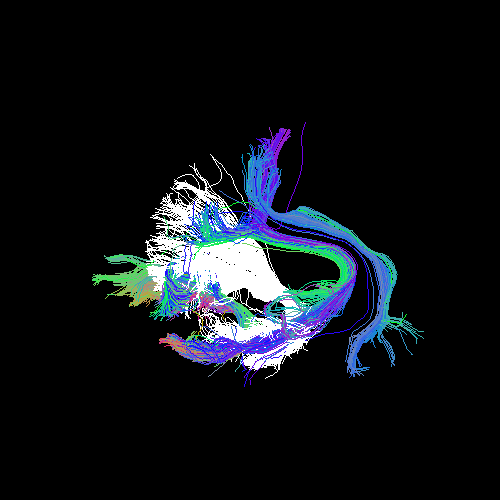

In [96]:
Image('pyAFQuicobundles_freesurfer_test_outputs/Left_Uncinate_1_tA.png')

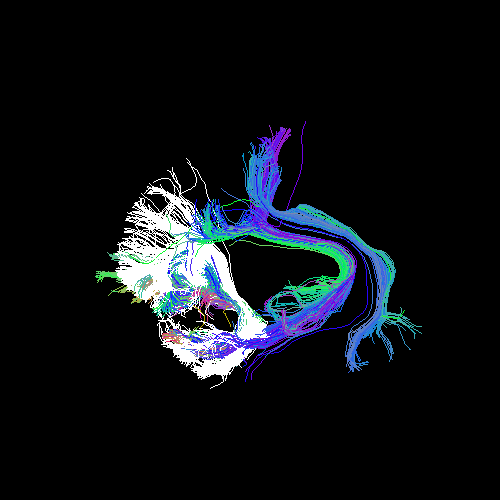

In [97]:
Image('pyAFQuicobundles_freesurfer_test_outputs/Left_Uncinate_1_tB.png')